# Building a Classifier using XGBoost on KDD Cup 1999 Dataset

The [KDD Cup 1999 dataset](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) contains a traces of network traffic in order to train a network intrusion detector that distingishes between `good` and `suspicious` connections. 

In [1]:
#!wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz 
#!gunzip kddcup.data_10_percent.gz

--2019-07-22 09:54:40--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2144903 (2.0M) [application/x-gzip]
Saving to: ‘kddcup.data_10_percent.gz’

100%[======================================>] 2,144,903    555KB/s   in 3.8s   

2019-07-22 09:54:44 (555 KB/s) - ‘kddcup.data_10_percent.gz’ saved [2144903/2144903]



In [2]:
#!mv kddcup.data_10_percent kddcup_10_percent.csv

In [3]:
!head kddcup_10_percent.csv

0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,39,39,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,49,49,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,59,59,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,212,1940,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1,69,1.00,0.00,1.00,0

### Load CSV Data through cuDF

In [4]:
import cudf
import numpy as np

The dataset lacks column headers so we need to specify them manually.

In [5]:
col_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label']

In [6]:
cudf.__version__

'0.8.0+0.g8fa7bd3.dirty'

In [7]:
gdf = cudf.io.read_csv('kddcup_10_percent.csv', names=col_names)

In [8]:
print('number of rows:', len(gdf))

number of rows: 494021


The inferred schema (column type):

In [9]:
print(gdf.dtypes)

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

### Categorize String Columns

XGBoost expects numerical values in its attributes. Categorical columns (e.g., String columns `protocol_type`, `service` and `flag`) need to be recoded to binary values ("dummified") via one-hot-encoding. This way values of categorical predictor variables are not falsely given a numeric relationship.

In [10]:
def one_hot_encode(gdf, column_name):
    # get category (i.e., a dictionary for the strings if the column)
    nvcat = gdf[column_name]._column.nvcategory
    keys = nvcat.keys().to_host()
    for k in keys:
        # iterate over all distinct values (keys) 
        # and insert a new Boolean column or that value 
        column_name_value = column_name + '_' + k
        gdf[column_name_value] = nvcat.values()
        gdf[column_name_value] = gdf[column_name_value] == nvcat.value(k)
    return gdf.drop(column_name)

In [11]:
print('number of columns before one-hot-encoding: ', len(gdf.columns))
gdf = one_hot_encode(gdf, 'protocol_type')
gdf = one_hot_encode(gdf, 'service')
gdf = one_hot_encode(gdf, 'flag')
print('number of columns after one-hot-encoding: ', len(gdf.columns))

number of columns before one-hot-encoding:  42
number of columns after one-hot-encoding:  119


The column `label` represent the labels in this supervised learning example. The value `normal.` is used to label normal traffic, all any other value specifies an attack.<br>
Strings are converted to cateogrical values. All attacks, i.e., rows with label `!= 'normal.'` are regarded attackes.  

In [12]:
labels = gdf.label._column.nvcategory
gdf['label'] = labels.values()
gdf['label_isattack'] = gdf.label != labels.value('normal.')
gdf.drop_column('label')

Next, we convert all columns to `float32` values for XGBoost.

In [13]:
for col in gdf:
    gdf[col] = gdf[col].astype(np.float32)

In [14]:
print(gdf.dtypes)

duration          float32
src_bytes         float32
dst_bytes         float32
land              float32
wrong_fragment    float32
                   ...   
flag_S2           float32
flag_S3           float32
flag_SF           float32
flag_SH           float32
label_isattack    float32
Length: 119, dtype: object


## Split Data in Training and Test Set

We split the data randomly into an training set, containing 80% of the rows, and a test set with the remaining 20%.

In [15]:
import numpy as np

In [16]:
is_train = np.random.rand(len(gdf)) < 0.8

We use numpy do generate a Boolean vector, which we then use to split dataframe.

In [17]:
gdf_train = gdf[is_train]
gdf_test = gdf[~is_train]

In [18]:
print('training data set: {} rows'.format(len(gdf_train)))
print('test data set:     {} rows'.format(len(gdf_test)))

training data set: 394792 rows
test data set:     99229 rows


We check the number of currences of attacks in the training and test datasets. 

In [19]:
print(gdf_train.label_isattack.value_counts())

1.0    317049
0.0     77743
dtype: int64


In [20]:
print(gdf_test.label_isattack.value_counts())

1.0    79694
0.0    19535
dtype: int64


It is not surprising that the datasets are unbalanced. Surprising is, however, that there are more attacks than non-attack labels.

Once, the original dataframe has been split into training and test sets it is no longer needed. <br>
We can explicitly delete it to free memory on the GPU.

In [21]:
del gdf

## XGBoost Training

In [22]:
import xgboost as xgb; 
print('XGBoost Version:', xgb.__version__)

XGBoost Version: 0.90.rapidsdev1


We split off the the label column into a separate series.

In [23]:
y_train = gdf_train.label_isattack
X_train = gdf_train.drop('label_isattack')

In [24]:
y_test = gdf_test.label_isattack
X_test = gdf_test.drop('label_isattack')

Next, we convert the cuDF dataframes into DMatrix objects required XGBoost. <br>
Note: the direct conversion requires the cuDF integration into XGBoost (https://github.com/dmlc/xgboost/pull/3997). The integration is available in cudf-interop branch https://github.com/rapidsai/xgboost. XGBoost that ships in the official RAPIDS AI container image supports direct conversion. 
XGBoost installed through the conda channel requires this conversion to occur via numpy (host memory).

In [25]:
#dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns)
dtrain = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_test.columns)
del gdf_train
del gdf_test

Next, we specify the parameters of XGBoost. 

In [26]:
params = {
  'n_gpus':       1,                 # number of GPUs to use
  'eval_metric':  'auc',             # evaluation metric
  'tree_method':  'gpu_hist',
  'objective':    'binary:logistic', # objective function binary logistic regression
}

We can train the tree gradient-boosted tree model using 5 boosting iterations.<br>
`evals` contains two DMatrix objects that are used for evaluation after every boosting iteration to report the accruacy using the Area-under Curve (AUC) metric.

In [27]:
%%time 
bst = xgb.train(params, dtrain, num_boost_round=5, evals=[(dtrain, 'train-AUC'), (dtest, 'test-AUC')])

[0]	train-AUC-auc:0.999527	test-AUC-auc:0.999527
[1]	train-AUC-auc:0.999648	test-AUC-auc:0.999648
[2]	train-AUC-auc:0.999872	test-AUC-auc:0.999872
[3]	train-AUC-auc:0.999874	test-AUC-auc:0.999874
[4]	train-AUC-auc:0.999874	test-AUC-auc:0.999874
CPU times: user 2.25 s, sys: 128 ms, total: 2.38 s
Wall time: 362 ms


Let's visualize the tree. For this, we need to make sure we have graphviz installed. 

In [28]:
#! pip install graphviz
#! apt -y install graphviz

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 6), dpi=300)
xgb.plot_tree(bst, ax=ax)
plt.show()

<Figure size 6000x1800 with 1 Axes>

Plot the importance of the features based on the fitted trees.

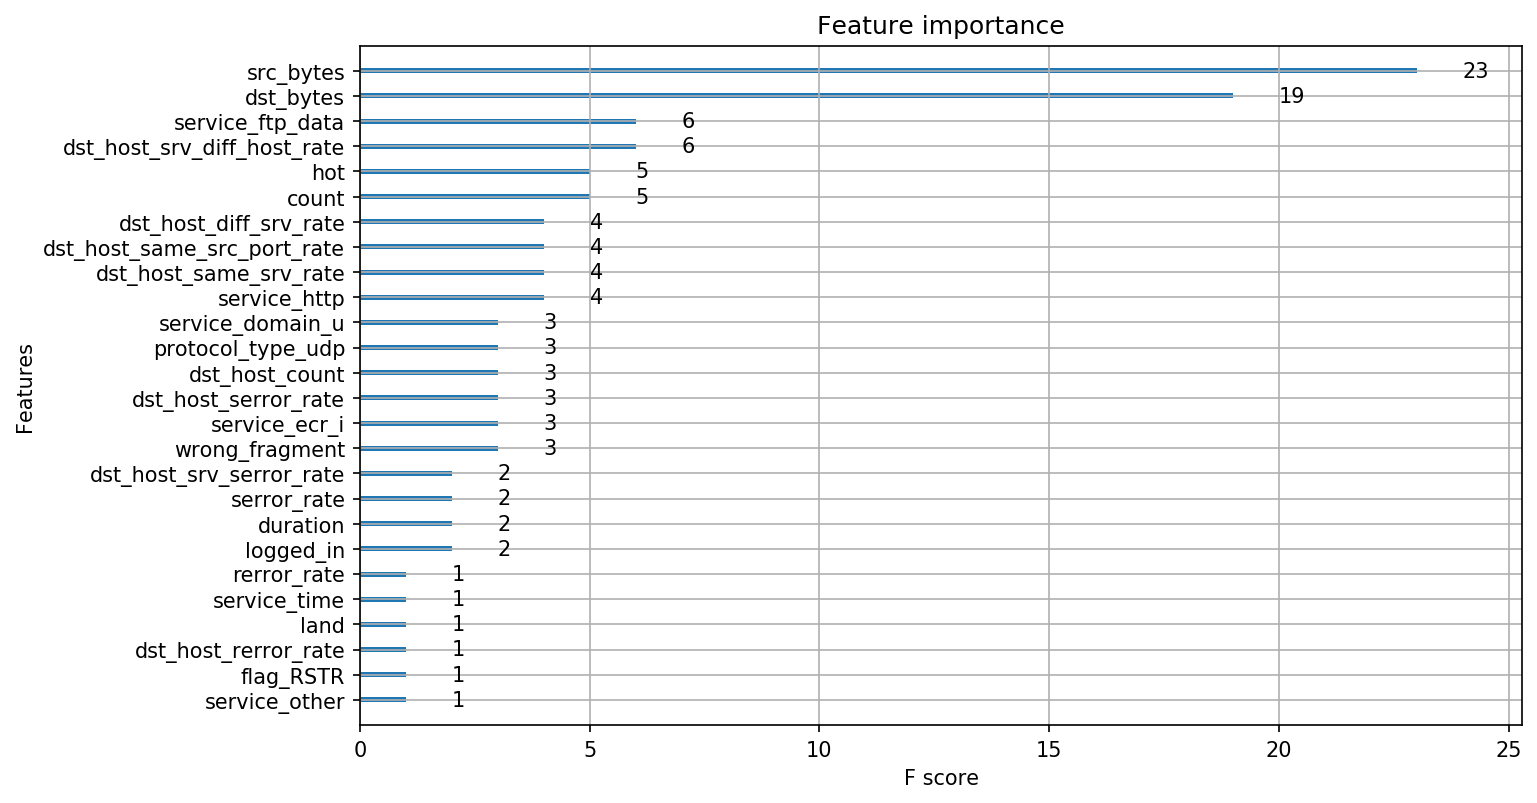

In [30]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
xgb.plot_importance(bst, ax=ax)
plt.show()

In [31]:
xgb.plot_importance?

Signature:
xgb.plot_importance(
    booster,
    ax=None,
    height=0.2,
    xlim=None,
    ylim=None,
    title='Feature importance',
    xlabel='F score',
    ylabel='Features',
    importance_type='weight',
    max_num_features=None,
    grid=True,
    show_values=True,
    **kwargs,
)
Docstring:
Plot importance based on fitted trees.

Parameters
----------
booster : Booster, XGBModel or dict
    Booster or XGBModel instance, or dict taken by Booster.get_fscore()
ax : matplotlib Axes, default None
    Target axes instance. If None, new figure and axes will be created.
grid : bool, Turn the axes grids on or off.  Default is True (On).
importance_type : str, default "weight"
    How the importance is calculated: either "weight", "gain", or "cover"

    * "weight" is the number of times a feature appears in a tree
    * "gain" is the average gain of splits which use the feature
    * "cover" is the average coverage of splits which use the feature
      where coverage is defined as the